In [1]:
import importlib
import model.cnn
importlib.reload(model.cnn)
from model.cnn import FFTResNet
print("cnn.py loaded")

cnn.py loaded


In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

In [ ]:
import random
from torch.utils.data import Subset,DataLoader

# random.seed(32)
# subset_indices = random.sample(range(len(train_dataset)),1000)
# idx_complement = set(range(len(train_dataset))) - set(subset_indices)
# dataset = Subset(train_dataset, indices= subset_indices)
# loader = DataLoader(dataset,batch_size = 32, shuffle=True)

In [ ]:
from torchvision.transforms import functional as TF
Y = [train_dataset[i][0] for i in range(len(train_dataset))]
Y = torch.stack(Y)


In [ ]:

translated_dataset= []
for i in range(Y.size(0)//100):
    for shift_h in range(28):
        for shift_v in range(28):
            translated_dataset.append(torch.roll(Y[i*100:(i*100)+1],shifts=(shift_h,shift_v),dims=(2,3)))
translated_dataset = torch.stack(translated_dataset).reshape(-1,1,28,28)


NameError: name 'Y' is not defined

In [13]:
sigma = 3.

In [14]:


def weights_calculation(x_input,dataset):
    b,c,h,w = dataset.shape
    dataset_flat = dataset.reshape(b,c,h*w).squeeze(1)
    x_input_flat = x_input.flatten()
    power = -0.5*torch.linalg.norm(dataset_flat - x_input_flat,dim=1)**2/sigma**2
    weights_vec = torch.softmax(power,dim=0)
    return weights_vec




In [15]:
def show_images(tensor):
    tensor = tensor.detach().cpu().permute(0,2,3,1)
    num_images = tensor.size(0)
    cols = num_images
    rows = 1
    
    plt.figure(figsize=(2 * num_images, 2))
    for i, img in enumerate(tensor):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)  # Remove `cmap='gray'` for RGB images
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

In [16]:
from torch.optim.lr_scheduler import LinearLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fftRN_model= FFTResNet(input_size=(28,28),c_out_list=[8,16,64,64,16,8])
optimizer = torch.optim.Adam(fftRN_model.parameters(),lr = 0.005)
scheduler = LinearLR(optimizer,0.6,1.,50)
loss_fn = torch.nn.MSELoss(reduction='mean')

# print(sum(p.numel() for p in fftRN_model.parameters() if p.requires_grad))

In [17]:
from tqdm import tqdm

def train(model,dataloader,optimizer,loss_fn,epochs = 101):
    print("Training starts")
    model.to(device)

    pb_bar = tqdm(range(epochs))
    for epoch in pb_bar:
        model.train()
        running_loss = 0.0
        for X, _ in dataloader:
            X = X.to(device) 
            Y = X + sigma * torch.randn_like(X)

            optimizer.zero_grad()
            outputs = model(Y)
            loss = loss_fn(outputs, X)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss/len(dataloader)
        last_lr = scheduler.get_last_lr()[0]
        pb_bar.set_description(f'Avg loss = {avg_loss:.3e}, lr = {last_lr:.3f}')
        
        scheduler.step()
        with torch.no_grad():
            if epoch%100==0:
                # print(f"Epoch {epoch} Loss : {avg_loss:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}")
                show_images(X[:4])
                show_images(Y[:4])
                show_images(outputs[:4])

def predict(model,input_tensor):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)
    return output.cpu()


Training starts


Avg loss = 1.731e-01, lr = 0.003:   0%|          | 0/1000 [00:03<?, ?it/s]

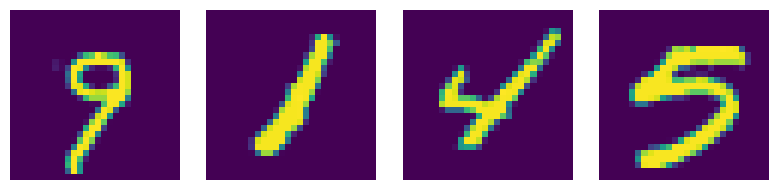

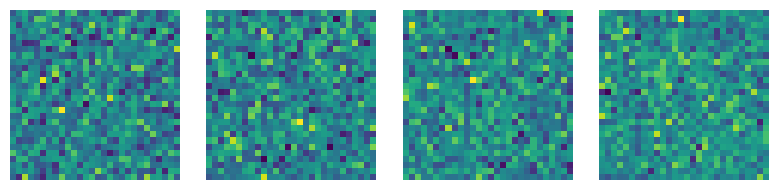

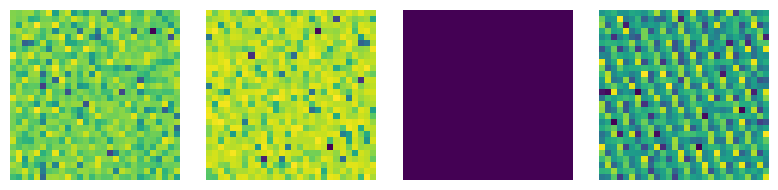

Avg loss = 8.721e-02, lr = 0.003:   1%|          | 7/1000 [00:20<47:25,  2.87s/it]


KeyboardInterrupt: 

In [18]:
# optimizer = torch.optim.Adam(fftRN_model.parameters(),lr = 0.00001)
# scheduler = LinearLR(optimizer,0.6,1.,50)
train(fftRN_model, loader, optimizer, loss_fn, epochs=1000)

In [ ]:
# torch.save(fftRN_model.state_dict(), 'fft_conv2d_fixed_sigma.pt')

In [19]:
fftRN_model.load_state_dict(torch.load('fft_conv2d_fixed_sigma.pt'))

<All keys matched successfully>

tensor(1.1026e-06)


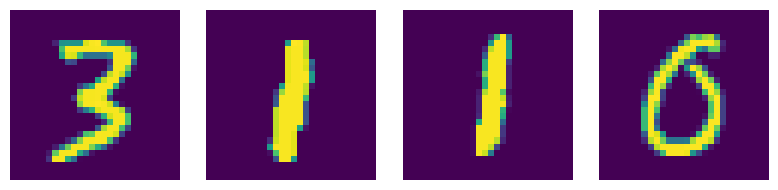

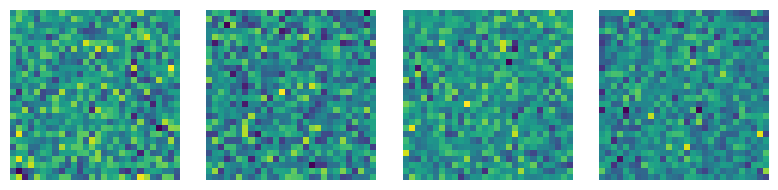

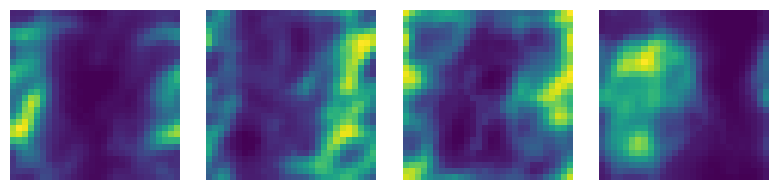

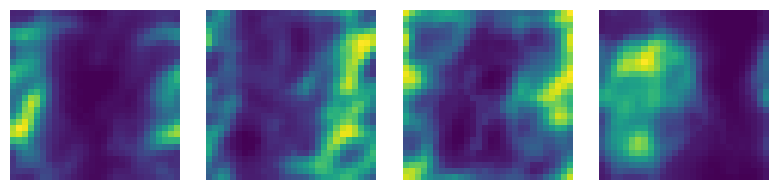

In [20]:
# -------------------Translation equivariance test--------------------
N = 50
trans = torch.randint(low=0,high=28,size=(N,2))
idx = torch.randint(low = 0, high= 100,size=(N,))
ims = torch.stack([dataset[i][0] for i in idx])
# input = torch.randn(100,1,28,28)

input = ims + sigma*torch.randn_like(ims)
output = predict(fftRN_model,input)
trans_output = torch.stack([torch.roll(output[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
trans_input =torch.stack([torch.roll(input[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
output_trans = predict(fftRN_model,trans_input)

diff = torch.mean(torch.linalg.norm((trans_output-output_trans).reshape(50,28*28),dim=1))
print(diff)
show_images(ims[:4])
show_images(input[:4])
show_images(trans_output[:4])
show_images(output_trans[:4])

**Comment:** Our Resnet is equivariance.

In [ ]:
# out = X.to(device)
# model.eval()
# with torch.no_grad():
#     for submodel in model.layers:
#         out = submodel(out)
#         show_images(out[:4, 0:1])

torch.Size([50, 784000, 1, 1, 1])


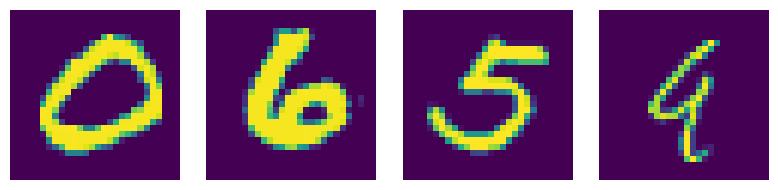

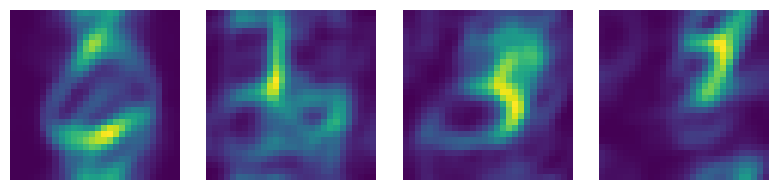

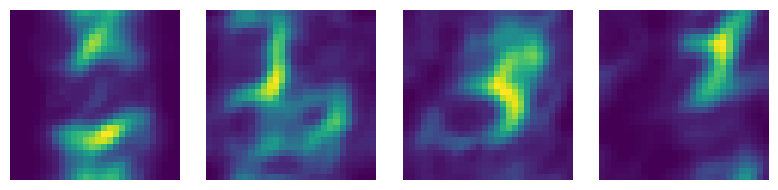

tensor(0.1339)


In [21]:
# -----------------Analytique solution rotation equivariance case---------------------
N = 50
ims_test = Y[torch.randint(0,100,(N,))]
ims_test_noised = ims_test + sigma*torch.randn_like(ims_test)
# im_test = im_test.squeeze(1)
ims_generated = predict(fftRN_model,ims_test_noised)
weights = [weights_calculation(x_input=im_noised,dataset=translated_dataset) for im_noised in ims_test_noised]
weights = torch.stack(weights)[:,:,None,None,None]
print(weights.shape)

sum = 0
for i in range(translated_dataset.size(0)//100):
    sum += torch.sum((translated_dataset[None,i*100:(i+1)*100]*weights[:,i*100:(i+1)*100]),dim=1,keepdim=False)

images_predicted_analytic = sum
show_images(ims_test[:4])
show_images(images_predicted_analytic[:4])
show_images(ims_generated[:4])
from einops import rearrange
relative_norm = torch.linalg.norm(rearrange(ims_generated-images_predicted_analytic,'b c h w -> b (c h w)'),dim=1)/torch.linalg.norm(rearrange(images_predicted_analytic,'b c h w -> b (c h w)'),dim=1)
diff=torch.mean(relative_norm)
print(diff)



torch.Size([4, 784000, 1, 1, 1])


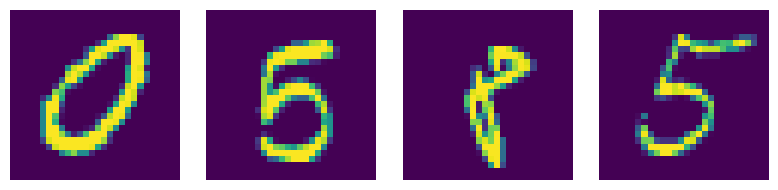

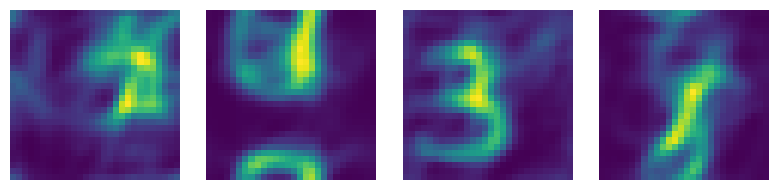

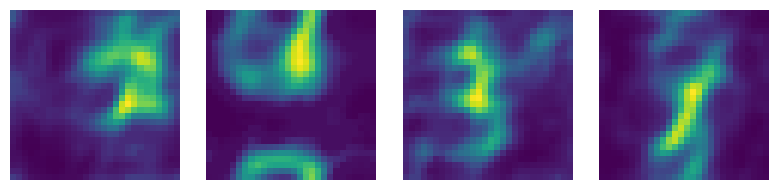

tensor(0.1673)


In [23]:
# -----------------Analytique solution rotation equivariance case---------------------
import numpy as np

N = 4
ims_test = torch.cat([train_dataset[i][0].unsqueeze(0) for i in np.random.choice(list(idx_complement), size = N)], dim = 0)
ims_test_noised = ims_test + sigma*torch.randn_like(ims_test)
# im_test = im_test.squeeze(1)
ims_generated = predict(fftRN_model,ims_test_noised)
weights = [weights_calculation(x_input=im_noised,dataset=translated_dataset) for im_noised in ims_test_noised]
weights = torch.stack(weights)[:,:,None,None,None]
print(weights.shape)

sum = 0
for i in range(translated_dataset.size(0)//100):
    sum += torch.sum((translated_dataset[None,i*100:(i+1)*100]*weights[:,i*100:(i+1)*100]),dim=1,keepdim=False)

images_predicted_analytic = sum
show_images(ims_test[:4])
show_images(images_predicted_analytic[:4])
show_images(ims_generated[:4])
from einops import rearrange
relative_norm = torch.linalg.norm(rearrange(ims_generated-images_predicted_analytic,'b c h w -> b (c h w)'),dim=1)/torch.linalg.norm(rearrange(images_predicted_analytic,'b c h w -> b (c h w)'),dim=1)
diff=torch.mean(relative_norm)
print(diff)


In [24]:
print(relative_norm)

tensor([0.1610, 0.1616, 0.2118, 0.1346])


In [25]:
print(-20*torch.log10(diff))


tensor(15.5325)


In [26]:
from scipy.stats import pearsonr
corr_avg = 0
for i in range(N):
    corr,_ = pearsonr(images_predicted_analytic[i].flatten(),ims_generated[i].flatten())
    corr_avg += corr
corr_avg = corr_avg/N
print(corr_avg)

0.9812306
